In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from dataset import ReadImages
from utils import *
from model.nn_utils import *
from model.siamese import *
from model.custom_modules import *
from os import path
import cv2

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

In [2]:
trainSetPath = 'data/pre_proc/CLICIDE_video_224sq'
testSetPath = 'data/pre_proc/CLICIDE_video_224sq/test'
mean_std_file = 'data/CLICIDE_224sq_train_ms.txt'
image_size = (3, 224, 224)
fit_size = True
cnn_model = models.resnet152
feature_size = (7, 7)
out_size = 464 # 1000 # 7 * 7 * 2048  # 6 * 6 * 256
conv_features = False

In [3]:
m, s = readMeanStd(mean_std_file)
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(m, s)])

def get_embeddings(net, dataset, out_size):
    C, H, W = image_size

    def batch(last, i, is_final, batch):
        embeddings = last
        n = len(batch)
        test_in = torch.Tensor(n, C, H, W).cuda()
        for j in range(n):
            test_in[j] = batch[j][0]

        out = net(Variable(test_in, volatile=True))
        out = out.view(out.size(0), out_size)
        for j, o in enumerate(out.data):
            embeddings[i + j] = o / (o.norm() + 1e-10)
        return embeddings
    init = torch.Tensor(len(dataset), out_size)
    return fold_batches(batch, init, dataset, 32)

def pre_proc(im_o):
    if fit_size:
        im_o = cv2.resize(im_o, (image_size[1], image_size[2]), cv2.INTER_CUBIC)
    return im_o

In [4]:
# training and test sets (scaled to 300 on the small side)
trainSetFull = ReadImages.readImageswithPattern(
    trainSetPath, lambda im: im.split('/')[-1].split('-')[0])
testSetFull = ReadImages.readImageswithPattern(
    testSetPath, lambda im: im.split('/')[-1].split('-')[0])

listLabel = [t[1] for t in trainSetFull if 'wall' not in t[1]]
labels = list(set(listLabel))
print(len(trainSetFull), len(testSetFull), len(labels))
print(labels)

(3245, 177, 464)
['29J', '29K', '29H', '29I', '29F', '29G', '29D', '29E', '29B', '29C', '29A', '34D', '34E', '34G', '34B', '34C', '34L', '34H', '34I', '34J', '34K', '6H', '3S', '3R', '3Q', '3P', '43C', '3T', '3K', '3J', '3I', '3H', '3O', '3N', '3M', '3L', '3C', '3B', '3A', '3G', '3F', '3E', '3D', '10J', '10H', '10I', '10B', '10C', '10A', '10F', '10G', '10D', '10E', '44C', '44A', '44E', '44D', '27A', '27B', '27C', '27D', '27E', '27F', '27G', '27H', '27I', '27J', '27K', '27L', '9A', '9C', '9B', '9E', '9D', '8J', '8K', '8H', '5J2', '8L', '33M', '33L', '33I', '33H', '33K', '33J', '33E', '33D', '33F', '33A', '33C', '33B', '8H2', '14F', '14G', '14D', '14E', '14B', '14C', '14L', '14M', '14J', '14K', '14H', '14I', '23L', '23M', '23N', '23O', '23H', '23J', '23K', '23D', '23E', '23F', '23G', '23A', '23B', '23C', '37I', '37K', '37J', '37L', '37A', '37B', '37E', '37D', '37G', '37F', '40G', '40F', '40E', '40C', '40B', '40A', '2D', '2E', '2F', '2G', '2A', '2B', '2C', '2H', '2I', '2J', '2K', '13C', '

In [104]:
trainSet, testSet = [], []
for im, lab in trainSetFull:
    im_o = pre_proc(imread_rgb(im))
    if lab in labels:
        im_out = trans(im_o)
        trainSet.append((im_out, lab))
for im, lab in testSetFull:
    im_o = pre_proc(imread_rgb(im))
    if lab in labels:
        im_out = trans(im_o)
        testSet.append((im_out, lab))
print(len(trainSet))
print(len(testSet))

3245
165


In [51]:
feature_net = cnn_model(pretrained=True)
if conv_features and (isinstance(feature_net, TuneClassif) or isinstance(feature_net, FeatureNet)):
    feature_net.classifier = nn.Sequential()
    feature_net.feature_reduc = nn.Sequential()
elif conv_features and (cnn_model is models.resnet152 or cnn_model is models.resnet101):
    feature_net.avgpool = nn.Sequential()
    feature_net.fc = nn.Sequential()
elif conv_features:
    feature_net.classifier = nn.Sequential()
feature_net = feature_net.cuda().eval()

In [40]:
test_embeddings = get_embeddings(feature_net, testSet, out_size)
ref_embeddings = get_embeddings(feature_net, trainSet, out_size)
sim = torch.mm(test_embeddings, ref_embeddings.t())
maxSim, maxIdx = sim.max(1)
maxLabel = []
for i in maxIdx:
    # get label from ref set which obtained highest score
    maxLabel.append(trainSet[i[0]][1])
correct = sum(testLabel == maxLabel[j] for j, (_, testLabel) in enumerate(testSet))
total = len(testSet)

In [41]:
print(correct, '/', total, '->', float(correct)/total)
print(mean_avg_precision(sim, testSet, trainSet))
for i in range(sim.size(0)):
    print(testSet[i][1], avg_precision(sim, i, testSet, trainSet), sum(testSet[i][1] == trainLab for _, trainLab in trainSet))

(128, '/', 165, '->', 0.7757575757575758)
0.738715688953
('10A', 0.4579122168910901, 4)
('10C', 1.0, 8)
('10J', 0.5433336658509232, 11)
('10J', 0.7326245553056342, 11)
('11A', 1.0, 10)
('11C', 0.004665748292931196, 5)
('11C', 1.0, 5)
('11F', 0.9135046897546898, 10)
('11J', 1.0, 5)
('11O', 0.007581061782778179, 5)
('12A', 1.0, 10)
('12D', 0.17127684407096172, 3)
('12E', 1.0, 10)
('12F', 1.0, 8)
('12G', 1.0, 14)
('12G', 0.9107383550339262, 14)
('12G', 0.05780875540892943, 14)
('12I', 1.0, 10)
('12K', 1.0, 6)
('12P', 0.947875816993464, 14)
('12P', 0.9950680272108844, 14)
('13A', 0.854059829059829, 10)
('14M', 0.9633333333333334, 5)
('15F', 1.0, 5)
('15G', 0.27264453651105447, 5)
('16C', 0.009551270797353609, 10)
('16F', 0.9904545454545455, 10)
('16O', 0.33323063747319265, 10)
('1C', 0.014491400426652453, 5)
('1F', 0.010508363143348817, 10)
('1G', 0.7558042863569179, 10)
('1G', 0.9216193528693528, 10)
('1H', 0.5348102260692412, 22)
('1J', 1.0, 6)
('1K', 1.0, 6)
('1L', 1.0, 4)
('1P', 1.0, 1

In [5]:
# output embeddings conforming to gordo's test program
import numpy as np
import os

In [6]:
full_dataset_path = '../gordo_retrieval/datasets/CLICIDE/jpg'
queries_path = '../gordo_retrieval/datasets/CLICIDE/lab'
queries = []
for e in np.sort(os.listdir(queries_path)):
    if e.endswith('_query.txt'):
        queries.append(e[:-len('_query.txt')])
queries = sorted(queries)
full_dataset, ref_dataset = [], []
for im in np.sort(os.listdir(full_dataset_path)):
    im_o = trans(pre_proc(imread_rgb(path.join(full_dataset_path, im))))
    lab = im.split('/')[-1].split('-')[0]
    full_dataset.append((im_o, lab))
    if im.split('/')[-1].split('.')[0] not in queries:
        ref_dataset.append((im_o, lab))
query_set = []
for name in queries:
    im_o = trans(pre_proc(imread_rgb(path.join(full_dataset_path, name + '.jpg'))))
    query_set.append((im_o, name.split('-')[0]))

In [7]:
class_net = TuneClassif(cnn_model(pretrained=True), len(labels), untrained=49)
class_net.load_state_dict(torch.load('data/finetune_classif/cli_best_resnet152_classif_finetuned.pth.tar'))
feature_net = FeatureNet(class_net, feature_size, classify=True)
feature_net.cuda().eval()
query_embeddings = get_embeddings(feature_net, query_set, out_size)
dataset_embeddings = get_embeddings(feature_net, full_dataset, out_size)
ref_embeddings = get_embeddings(feature_net, ref_dataset, out_size)
np.save('data/CLICIDE_S800_L2_queries.npy', query_embeddings.numpy())
np.save('data/CLICIDE_S800_L2_dataset.npy', dataset_embeddings.numpy())

In [8]:
def avg_precision(sim, i, test_set, ref_set, kth=1):
    test_label = test_set[i][1]
    n_pos = sum(test_label == ref_label for _, ref_label in ref_set)
    n_pos -= (kth - 1)
    if n_pos <= 0:
        return None
    old_recall, old_precision, ap = 0.0, 1.0, 0.0
    intersect_size, j = 0, 0
    _, ranked_list = sim[i].sort(dim=0, descending=True)
    ev = []
    for n, k in enumerate(ranked_list):
        if n + 1 < kth:
            continue
        if ref_set[k][1] == test_label:
            intersect_size += 1

        recall = intersect_size / float(n_pos)
        precision = intersect_size / (j + 1.0)
        ap += (recall - old_recall) * ((old_precision + precision) / 2.0)
        if abs(recall - old_recall) > 1e-8:
            ev.append((recall - old_recall) * ((old_precision + precision) / 2.0))
        old_recall, old_precision = recall, precision
        j += 1
    return ap


def mean_avg_precision(sim, test_set, ref_set, kth=1):
    aps = []
    for i in range(sim.size(0)):
        # compute ap for each test image
        ap = avg_precision(sim, i, test_set, ref_set, kth)
        if ap is not None:
            aps.append(ap)
    return sum(aps) / float(len(aps))

In [9]:
sim = torch.mm(query_embeddings, ref_embeddings.t())
print(mean_avg_precision(sim, query_set, ref_dataset))
for i in range(sim.size(0)):
    print(query_set[i][1], avg_precision(sim, i, query_set, ref_dataset), sum(query_set[i][1] == ref_label for _, ref_label in ref_dataset))

0.740136169057
('10A', 0.4409282107491826, 4)
('10C', 1.0, 8)
('10J', 0.6335985777014369, 11)
('10J', 0.7358812495714634, 11)
('11A', 1.0, 10)
('11C', 0.0042217471376596784, 5)
('11C', 1.0, 5)
('11F', 0.8726713564213565, 10)
('11J', 1.0, 5)
('11O', 0.01155865549839627, 5)
('12A', 1.0, 10)
('12D', 0.4941919191919191, 3)
('12E', 1.0, 10)
('12F', 1.0, 8)
('12G', 0.9897697540554684, 14)
('12G', 0.8716643144373256, 14)
('12G', 0.1224689957359945, 14)
('12I', 1.0, 10)
('12K', 1.0, 6)
('12P', 0.9476667590112967, 14)
('12P', 0.9396745852491194, 14)
('13A', 0.8539775461466638, 10)
('14M', 1.0, 5)
('15F', 0.9633333333333334, 5)
('15G', 0.2910681093439438, 5)
('16C', 0.015282556818055964, 10)
('16F', 1.0, 10)
('16O', 0.32239740825994617, 10)
('1C', 0.013745144705165533, 5)
('1F', 0.008179373910785055, 10)
('1G', 0.8741915478312537, 10)
('1G', 0.9759615384615384, 10)
('1H', 0.5700877916948771, 22)
('1J', 1.0, 6)
('1K', 1.0, 6)
('1L', 1.0, 4)
('1P', 1.0, 10)
('1P', 1.0, 10)
('1R', 0.008465613843131

In [70]:
feature_net1 = TuneClassif(cnn_model(pretrained=True), len(labels), untrained=49)
feature_net1.load_state_dict(torch.load('data/finetune_classif/cli_best_resnet152_classif_finetuned.pth.tar'))
feature_net1 = feature_net1.eval().cuda()
feature_net2 = TuneClassif(cnn_model(pretrained=True), len(labels), untrained=49)
feature_net2.load_state_dict(torch.load('data/finetune_classif/cli_best_resnet152_classif_finetuned.pth.tar'))
feature_net2.feature_reduc = nn.Sequential(nn.AvgPool2d(7, stride=1))
feature_net2.classifier = convolutionalize(feature_net2.classifier[0], (1, 1))
feature_net2 = feature_net2.eval().cuda()

In [97]:
test_img = '/video/CLICIDE/test/30P-0976.JPG'
test_label = test_img.split('/')[-1].split('-')[0]
test_tensor = torch.Tensor(1, 3, 224, 224).cuda()
test_tensor[0] = trans(cv2.resize(imread_rgb(test_img), (224, 224), cv2.INTER_CUBIC))
test_out = feature_net1(Variable(test_tensor, volatile=True))
print(test_out.data.max(1))

sc = scale_cv(448)
img = trans(sc(imread_rgb(test_img)))
in_tensor = torch.Tensor(1, *img.size()).cuda()
in_tensor[0] = img
print(test_label, labels.index(test_label), in_tensor.size())
out1 = feature_net2.features(Variable(in_tensor, volatile=True))
print(out1.size())
out2 = feature_net2.feature_reduc(out1)
out3 = feature_net2.classifier(out2)
max_v, max_l = out3.data.max(1)
print(max_v.size(), max_l.size())

(
 8.0098
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]
, 
 266
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
)
('30P', 384, torch.Size([1, 3, 597, 448]))
torch.Size([1, 2048, 19, 14])
(torch.Size([1, 1, 13, 8]), torch.Size([1, 1, 13, 8]))


In [98]:
max_values = max_v.view(max_v.size(2), max_v.size(3)).cpu().numpy()
cmap = plt.cm.get_cmap('Paired', len(labels) + 1)
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[len(labels)] = (.0, .0, .0, .0)
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
max_labels = max_l.view(max_l.size(2), max_l.size(3)).cpu().numpy()
# all labels where the max value is too small are ignored
max_labels[max_values < np.mean(max_values)] = len(labels)
labels_set = np.array(sorted(list(set(max_labels.flatten()))))

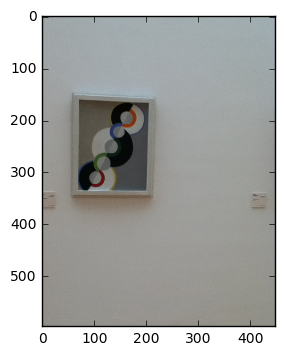

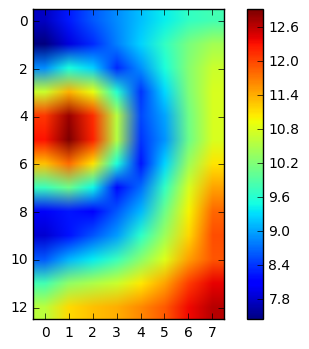

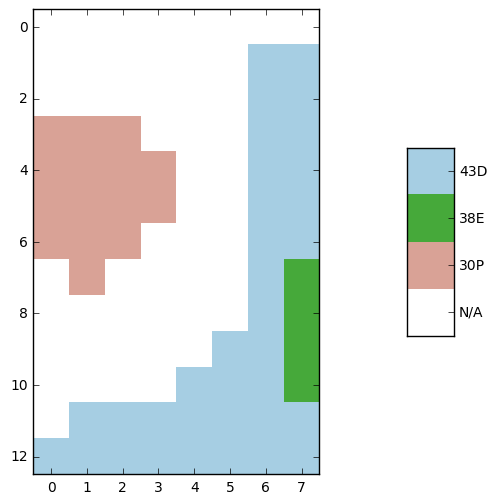

In [99]:
plt.imshow(sc(imread_rgb(test_img)))
plt.savefig('sample1_10A-0519.png', bbox_inches='tight')

fig, ax = plt.subplots()
cax = ax.imshow(max_values)
fig.colorbar(cax)
plt.savefig('sample1_heatmap.png', bbox_inches='tight')

fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[8, 1])
ax1 = plt.subplot(gs[0])
ax1.imshow(max_labels, cmap, interpolation='nearest')
ax2 = plt.subplot(gs[1])
ax2.imshow(labels_set[:, np.newaxis], cmap, interpolation='nearest')
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().tick_right()
ax2.set_yticks(range(len(labels_set)))
ax2.set_yticklabels([labels[lab] if lab < len(labels) else 'N/A' for lab in labels_set])

plt.savefig('sample1_labels.png', bbox_inches='tight')

In [89]:
class_net = TuneClassifSub(models.resnet152(pretrained=True), 464, (7, 7))
class_net.load_state_dict(torch.load('data/20170427-170559-541759_best_classif.pth.tar'))
class_net = class_net.eval().cuda()

total, correct = 0, 0

for i, (im, lab) in enumerate(testSet):
    t = im.unsqueeze(0).cuda()
    out = class_net(Variable(t)).data
    max_pred, predicted = torch.max(out, 1)
    _, max_subp = torch.max(max_pred.view(-1), 0)
    predicted = predicted.view(-1)[max_subp[0]]
    total += 1
    correct += (labels.index(lab) == predicted)
    if labels.index(lab) != predicted:
        count = 0
        for j, (im, lab) in enumerate(testSetFull):
            if lab not in labels:
                count += 1
            if i + count == j:
                break
        print(lab, i, i + count, testSetFull[i + count])
print(correct, total)

IOError: [Errno 2] No such file or directory: 'data/20170427-170559-541759_best_classif.pth.tar'